In [214]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

from smoker_status.config import RAW_DATA_DIR
from smoker_status.features import (
    add_BMI,
    add_de_ritis_level,
    add_GGT_level,
    create_encoded_X,
    set_anemia,
    set_ALT_class,
    set_AST_class,
    set_blood_pressure_class,
    set_BMI_class,
    set_creatinine_class,
    set_cholesterol_class,
    set_FPG_class,
    set_HDL_class,
    set_LDL_class,
    set_triglyceride_class,
    update_blindness_zero,
)

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

df = pd.read_csv(RAW_DATA_DIR / 'train.csv')

In [216]:
X = df.drop(['id'], axis=1)
X.describe()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin       

In [217]:
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1


In [218]:
def set_sex(row: pd.Series):
    """Use with `pandas.DataFrame.apply`. Must use axis=1 to apply to
    each row.
    """
    # Male, increase score by 1. Female, decrease score by 1. If score == 0,
    # then neither had majority, so np.nan
    score = 0
    # Rough heuristic based on Table 2 from doi: 10.4178/epih.e2022024
    if row['age'] >= 19 and row['age'] <= 29:
        if row['height(cm)'] <= 165:
            score -= 1
        elif row['height(cm)'] >= 170:
            score += 1
        if row['weight(kg)'] <= 55:
            score -= 1
        elif row['weight(kg)'] >= 70:
            score += 1
        else:  # [60, 65]
            pass
    elif row['age'] >= 30 and row['age'] <= 39:
        if row['height(cm)'] <= 165:
            score -= 1
        elif row['height(cm)'] >= 170:
            score += 1
        if row['weight(kg)'] <= 60:
            score -= 1
        elif row['weight(kg)'] >= 75:
            score += 1
        else:  # [65, 70]
            pass
    elif row['age'] >= 40 and row['age'] <= 49:
        if row['height(cm)'] <= 160:
            score -= 1
        elif row['height(cm)'] >= 170:
            score += 1
        else:  # [165]
            pass
        if row['weight(kg)'] <= 60:
            score -= 1
        elif row['weight(kg)'] >= 70:
            score += 1
        else:  # [65]
            pass
    elif row['age'] >= 50 and row['age'] <= 59:
        if row['height(cm)'] <= 160:
            score -= 1
        elif row['height(cm)'] >= 165:
            score += 1
        if row['weight(kg)'] <= 60:
            score -= 1
        elif row['weight(kg)'] >= 70:
            score += 1
        else:  # [65]
            pass
    elif row['age'] >= 60 and row['age'] <= 69:
        if row['height(cm)'] <= 160:
            score -= 1
        elif row['height(cm)'] >= 165:
            score += 1
        if row['weight(kg)'] <= 55:
            score -= 1
        elif row['weight(kg)'] >= 70:
            score += 1
        else:  # [60, 65]
            pass
    elif row['age'] >= 70:
        if row['height(cm)'] <= 155:
            score -= 1
        elif row['height(cm)'] >= 160:
            score += 1
        if row['weight(kg)'] <= 55:
            score -= 1
        elif row['weight(kg)'] >= 65:
            score += 1
        else:  # [60]
            pass
    return score


X['sex'] = df.apply(set_sex, axis=1)
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0,2
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1,2
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,2
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0,-2
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0,-2
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1,2


In [219]:
def count_missing_values(dataframe: pd.DataFrame):
    """https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/"""
    for column in dataframe.columns:
        # count number of rows with missing values
        n_miss = dataframe[column].isnull().sum()
        perc = n_miss / dataframe.shape[0] * 100
        print(f'> {column}, Missing {n_miss:d} ({perc:f}%)')


count_missing_values(X)

> age, Missing 0 (0.000000%)
> height(cm), Missing 0 (0.000000%)
> weight(kg), Missing 0 (0.000000%)
> waist(cm), Missing 0 (0.000000%)
> eyesight(left), Missing 0 (0.000000%)
> eyesight(right), Missing 0 (0.000000%)
> hearing(left), Missing 0 (0.000000%)
> hearing(right), Missing 0 (0.000000%)
> systolic, Missing 0 (0.000000%)
> relaxation, Missing 0 (0.000000%)
> fasting blood sugar, Missing 0 (0.000000%)
> Cholesterol, Missing 0 (0.000000%)
> triglyceride, Missing 0 (0.000000%)
> HDL, Missing 0 (0.000000%)
> LDL, Missing 0 (0.000000%)
> hemoglobin, Missing 0 (0.000000%)
> Urine protein, Missing 0 (0.000000%)
> serum creatinine, Missing 0 (0.000000%)
> AST, Missing 0 (0.000000%)
> ALT, Missing 0 (0.000000%)
> Gtp, Missing 0 (0.000000%)
> dental caries, Missing 0 (0.000000%)
> smoking, Missing 0 (0.000000%)
> sex, Missing 0 (0.000000%)


In [220]:
imputer = KNNImputer(n_neighbors=5, missing_values=0)
X_trans = imputer.fit_transform(X[['age', 'height(cm)', 'weight(kg)', 'sex']])
sum(np.isnan(X_trans).flatten())

np.int64(0)

In [221]:
X_full_sex = pd.DataFrame(X_trans, columns=['age', 'height(cm)', 'weight(kg)', 'sex'])
X['sex'] = X_full_sex['sex']
count_missing_values(X)

> age, Missing 0 (0.000000%)
> height(cm), Missing 0 (0.000000%)
> weight(kg), Missing 0 (0.000000%)
> waist(cm), Missing 0 (0.000000%)
> eyesight(left), Missing 0 (0.000000%)
> eyesight(right), Missing 0 (0.000000%)
> hearing(left), Missing 0 (0.000000%)
> hearing(right), Missing 0 (0.000000%)
> systolic, Missing 0 (0.000000%)
> relaxation, Missing 0 (0.000000%)
> fasting blood sugar, Missing 0 (0.000000%)
> Cholesterol, Missing 0 (0.000000%)
> triglyceride, Missing 0 (0.000000%)
> HDL, Missing 0 (0.000000%)
> LDL, Missing 0 (0.000000%)
> hemoglobin, Missing 0 (0.000000%)
> Urine protein, Missing 0 (0.000000%)
> serum creatinine, Missing 0 (0.000000%)
> AST, Missing 0 (0.000000%)
> ALT, Missing 0 (0.000000%)
> Gtp, Missing 0 (0.000000%)
> dental caries, Missing 0 (0.000000%)
> smoking, Missing 0 (0.000000%)
> sex, Missing 0 (0.000000%)


In [222]:
X[X['sex'] > 0].describe()  # male
X[X['sex'] < 0].describe()  # female
# TODO: first use sex to figure out healthy ranges for BMI and other
# health stuff
# TODO: then convert sex to categorical M or F, and do one hot encoding

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex
count,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.00000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000
mean,48.102137,157.440490,56.333518,77.039575,0.939270,0.931628,1.030848,1.030518,119.983596,74.856193,96.542268,197.399569,102.808492,62.059450,114.86462,13.869009,1.084072,0.798015,24.346555,21.052236,26.936239,0.161288,0.205756,-1.582333
std,10.618427,6.194094,6.863181,7.430205,0.402633,0.388671,0.172906,0.172010,13.586715,9.134896,14.600432,29.730029,55.540888,14.736449,29.56016,1.396359,0.367897,0.169646,9.022559,11.945094,26.104331,0.367799,0.404256,0.567977
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,46.000000,91.000000,8.000000,9.000000,10.00000,4.900000,1.000000,0.100000,6.000000,1.000000,3.000000,0.000000,0.000000,-2.000000
25%,40.000000,155.000000,50.000000,72.000000,0.700000,0.700000,1.000000,1.000000,110.000000,69.000000,88.000000,175.000000,63.000000,51.000000,93.00000,13.000000,1.000000,0.700000,19.000000,14.000000,15.000000,0.000000,0.000000,-2.000000
50%,45.000000,155.000000,55.000000,77.000000,1.000000,1.000000,1.000000,1.000000,119.000000,75.000000,94.000000,198.000000,88.000000,61.000000,114.00000,13.700000,1.000000,0.800000,23.000000,18.000000,20.000000,0.000000,0.000000,-2.000000
75%,55.000000,160.000000,60.000000,82.000000,1.200000,1.200000,1.000000,1.000000,130.000000,80.000000,102.000000,221.000000,132.000000,72.000000,136.00000,14.700000,1.000000,0.900000,27.000000,25.000000,30.000000,0.000000,0.000000,-1.000000
max,85.000000,175.000000,85.000000,125.800000,9.900000,9.900000,2.000000,2.000000,213.000000,120.000000,365.000000,351.000000,466.000000,136.000000,1660.00000,21.000000,6.000000,9.900000,778.000000,745.000000,816.000000,1.000000,1.000000,-0.200000


In [223]:
X['anemia'] = X.apply(set_anemia, axis=1)
X[X['sex'] > 0].describe()  # male, anemia mean: 0.01, std: 0.15
# X[X['sex'] < 0].describe()  # femmale, anemia mean: 0.08, std: 0.35

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia
count,92444.000000,92444.000000,92444.000000,92444.000000,92444.00000,92444.000000,92444.000000,92444.000000,92444.000000,92444.00000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000
mean,41.563498,170.923327,74.956471,87.311202,1.05388,1.051119,1.019006,1.018292,124.324964,78.33245,99.660897,194.637337,145.545195,51.366871,114.421985,15.467627,1.067122,0.961242,26.362663,30.523906,42.922764,0.224525,0.604755,1.635522,0.017275
std,11.923572,5.476381,9.662350,7.353712,0.39482,0.387243,0.136547,0.134007,11.739804,8.60215,15.706657,27.334829,67.465405,11.446143,27.099804,1.023463,0.332441,0.153083,9.684511,20.054878,32.829402,0.417271,0.488906,0.512388,0.145365
min,20.000000,150.000000,50.000000,51.000000,0.10000,0.100000,1.000000,1.000000,80.000000,47.00000,48.000000,77.000000,11.000000,18.000000,1.000000,5.800000,1.000000,0.100000,9.000000,1.000000,2.000000,0.000000,0.000000,0.200000,0.000000
25%,35.000000,165.000000,70.000000,82.000000,0.90000,0.900000,1.000000,1.000000,117.000000,72.00000,91.000000,176.000000,94.000000,43.000000,96.000000,14.900000,1.000000,0.900000,20.000000,19.000000,23.000000,0.000000,0.000000,1.000000,0.000000
50%,40.000000,170.000000,75.000000,87.000000,1.00000,1.000000,1.000000,1.000000,124.000000,79.00000,97.000000,196.000000,138.000000,49.000000,114.000000,15.500000,1.000000,1.000000,24.000000,26.000000,34.000000,0.000000,1.000000,2.000000,0.000000
75%,50.000000,175.000000,80.000000,92.000000,1.20000,1.200000,1.000000,1.000000,132.000000,84.00000,105.000000,214.000000,184.000000,58.000000,132.000000,16.100000,1.000000,1.100000,30.000000,38.000000,52.000000,0.000000,1.000000,2.000000,0.000000
max,85.000000,190.000000,130.000000,127.000000,9.90000,9.900000,2.000000,2.000000,203.000000,133.00000,375.000000,393.000000,766.000000,135.000000,1860.000000,20.400000,5.000000,5.900000,656.000000,2914.000000,999.000000,1.000000,1.000000,2.000000,3.000000


In [224]:
# Adding cholesterol classes
X['HDL class'] = X.apply(set_HDL_class, axis=1)
X['LDL class'] = X.apply(set_LDL_class, axis=1)
X['Cholesterol class'] = X.apply(set_cholesterol_class, axis=1)
X.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,98.352552,195.796165,127.616046,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365,0.285549,0.044381,1.252844,1.031220,0.509149
std,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,15.329740,28.396959,66.188989,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063,1.676109,0.258191,0.610643,0.856905,0.595055
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,46.000000,77.000000,8.000000,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000,-2.000000,0.000000,1.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,115.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,165.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000,2.000000,0.000000,2.000000,2.000000,1.000000
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,375.000000,393.000000,766.000000,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000,2.000000,3.000000,2.000000,4.000000,2.000000


In [225]:
X['blood pressure class'] = X.apply(set_blood_pressure_class, axis=1)
X[X['sex'] > 0].describe()
# X[X['sex'] < 0].describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class
count,92444.000000,92444.000000,92444.000000,92444.000000,92444.00000,92444.000000,92444.000000,92444.000000,92444.000000,92444.00000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.00000,92444.000000
mean,41.563498,170.923327,74.956471,87.311202,1.05388,1.051119,1.019006,1.018292,124.324964,78.33245,99.660897,194.637337,145.545195,51.366871,114.421985,15.467627,1.067122,0.961242,26.362663,30.523906,42.922764,0.224525,0.604755,1.635522,0.017275,1.082688,1.020867,0.48491,1.291961
std,11.923572,5.476381,9.662350,7.353712,0.39482,0.387243,0.136547,0.134007,11.739804,8.60215,15.706657,27.334829,67.465405,11.446143,27.099804,1.023463,0.332441,0.153083,9.684511,20.054878,32.829402,0.417271,0.488906,0.512388,0.145365,0.577590,0.824828,0.57789,0.998468
min,20.000000,150.000000,50.000000,51.000000,0.10000,0.100000,1.000000,1.000000,80.000000,47.00000,48.000000,77.000000,11.000000,18.000000,1.000000,5.800000,1.000000,0.100000,9.000000,1.000000,2.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,35.000000,165.000000,70.000000,82.000000,0.90000,0.900000,1.000000,1.000000,117.000000,72.00000,91.000000,176.000000,94.000000,43.000000,96.000000,14.900000,1.000000,0.900000,20.000000,19.000000,23.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000
50%,40.000000,170.000000,75.000000,87.000000,1.00000,1.000000,1.000000,1.000000,124.000000,79.00000,97.000000,196.000000,138.000000,49.000000,114.000000,15.500000,1.000000,1.000000,24.000000,26.000000,34.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.00000,2.000000
75%,50.000000,175.000000,80.000000,92.000000,1.20000,1.200000,1.000000,1.000000,132.000000,84.00000,105.000000,214.000000,184.000000,58.000000,132.000000,16.100000,1.000000,1.100000,30.000000,38.000000,52.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,1.00000,2.000000
max,85.000000,190.000000,130.000000,127.000000,9.90000,9.900000,2.000000,2.000000,203.000000,133.00000,375.000000,393.000000,766.000000,135.000000,1860.000000,20.400000,5.000000,5.900000,656.000000,2914.000000,999.000000,1.000000,1.000000,2.000000,3.000000,2.000000,4.000000,2.00000,4.000000


In [226]:
add_GGT_level(X)
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1,1.0,0,1,0,0,2,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0,2.0,0,1,1,0,2,2
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1,2.0,0,1,0,0,0,3
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,2.0,0,0,1,0,2,1
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1,-2.0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0,-2.0,0,2,2,1,2,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0,0.8,0,2,1,1,2,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0,-2.0,2,2,0,0,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1,2.0,0,1,0,0,3,2


In [227]:
X['triglyceride class'] = X.apply(set_triglyceride_class, axis=1)
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1,1.0,0,1,0,0,2,1,2
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0,2.0,0,1,1,0,2,2,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1,2.0,0,1,0,0,0,3,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,2.0,0,0,1,0,2,1,2
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1,-2.0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0,-2.0,0,2,2,1,2,0,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0,0.8,0,2,1,1,2,0,2
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0,-2.0,2,2,0,0,0,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1,2.0,0,1,0,0,3,2,0


In [228]:
X['creatinine class'] = X.apply(set_creatinine_class, axis=1)
X[(X['sex'] > 0) & (X['creatinine class'] == 1)]
X[(X['sex'] < 0) & (X['creatinine class'] == 1)]

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class
54,45,155,65,87.0,0.7,0.7,1,1,130,80,95,238,86,59,162,14.3,1,1.0,23,28,23,0,0,-1.0,0,1,3,1,2,2,0,1
58,40,165,65,89.0,1.0,1.0,1,1,107,60,91,184,278,41,87,15.6,1,1.0,47,34,51,0,1,-0.2,0,1,0,0,0,3,2,1
78,40,165,60,80.0,1.0,1.0,1,1,107,66,89,225,67,66,146,13.7,1,1.2,19,11,15,0,0,-1.0,0,2,2,1,0,0,0,1
118,65,160,65,87.5,0.6,0.6,1,1,114,74,98,214,260,45,117,15.8,1,1.4,37,37,19,0,0,-1.0,0,1,1,1,0,1,2,1
120,40,165,55,75.0,1.2,1.2,1,1,109,68,110,172,112,69,81,14.3,1,1.0,23,19,25,0,1,-1.0,0,2,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159174,40,155,45,66.0,0.8,0.6,1,1,107,72,83,251,54,74,167,12.4,1,1.0,27,21,13,1,0,-2.0,0,2,3,2,0,0,0,1
159189,55,160,60,85.5,1.2,1.2,1,1,110,70,115,148,120,40,85,13.7,1,1.0,27,24,20,0,1,-2.0,0,1,0,0,0,1,0,1
159190,55,160,60,79.0,0.9,1.0,1,1,102,63,78,166,47,67,88,15.4,1,1.0,39,29,25,0,1,-2.0,0,2,0,0,0,2,0,1
159211,40,160,65,86.0,1.0,1.2,1,1,133,85,117,158,152,41,87,16.2,1,1.0,25,52,38,0,0,-1.0,0,1,0,0,2,3,1,1


In [229]:
X['ALT class'] = X.apply(set_ALT_class, axis=1)
X['AST class'] = X.apply(set_AST_class, axis=1)
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1,1.0,0,1,0,0,2,1,2,0,0,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0,2.0,0,1,1,0,2,2,0,0,0,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1,2.0,0,1,0,0,0,3,1,0,0,0
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,2.0,0,0,1,0,2,1,2,0,0,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1,-2.0,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0,-2.0,0,2,2,1,2,0,0,0,1,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0,0.8,0,2,1,1,2,0,2,0,0,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0,-2.0,2,2,0,0,0,0,0,0,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1,2.0,0,1,0,0,3,2,0,0,0,0


In [230]:
add_de_ritis_level(X)

In [231]:
X['FPG class'] = X.apply(set_FPG_class, axis=1)
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,AST/ALT,FPG class
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1,1.0,0,1,0,0,2,1,2,0,0,0,0.880000,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0,2.0,0,1,1,0,2,2,0,0,0,0,1.173913,3
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1,2.0,0,1,0,0,0,3,1,0,0,0,0.870968,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,2.0,0,0,1,0,2,1,2,0,0,0,0.740741,1
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1,-2.0,0,1,0,0,1,1,0,0,0,0,1.461538,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0,-2.0,0,2,2,1,2,0,0,0,1,0,0.961538,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0,0.8,0,2,1,1,2,0,2,0,0,0,1.050000,1
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0,-2.0,2,2,0,0,0,0,0,0,0,0,1.666667,1
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1,2.0,0,1,0,0,3,2,0,0,0,0,1.294118,2


In [232]:
add_BMI(X)
X['BMI class'] = X.apply(set_BMI_class, axis=1)

In [233]:
update_blindness_zero(X)
X

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,AST/ALT,FPG class,BMI,BMI class
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1,1.0,0,1,0,0,2,1,2,0,0,0,0.880000,1,22.038567,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0,2.0,0,1,1,0,2,2,0,0,0,0,1.173913,3,23.875115,2
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1,2.0,0,1,0,0,0,3,1,0,0,0,0.870968,1,25.951557,3
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,2.0,0,0,1,0,2,1,2,0,0,0,0.740741,1,29.320988,3
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1,-2.0,0,1,0,0,1,1,0,0,0,0,1.461538,1,22.038567,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,64,238,47,72,159,14.5,1,0.8,25,26,13,0,0,-2.0,0,2,2,1,2,0,0,0,1,0,0.961538,0,18.730489,1
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,89,213,202,64,108,14.5,1,0.6,21,20,18,0,0,0.8,0,2,1,1,2,0,2,0,0,0,1.050000,1,31.217482,4
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,84,189,45,87,93,10.9,1,0.6,15,9,12,0,0,-2.0,2,2,0,0,0,0,0,0,0,0,1.666667,1,19.531250,1
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,122,165,148,55,80,14.4,1,1.1,22,17,37,0,1,2.0,0,1,0,0,3,2,0,0,0,0,1.294118,2,27.548209,3


In [234]:
X[X['sex'] > 0].describe()  # male

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,AST/ALT,FPG class,BMI,BMI class
count,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.00000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.00000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000,92444.000000
mean,41.563498,170.923327,74.956471,87.311202,1.045741,1.043622,1.019006,1.018292,124.324964,78.33245,99.660897,194.637337,145.545195,51.366871,114.421985,15.467627,1.067122,0.961242,26.362663,30.523906,42.922764,0.224525,0.604755,1.635522,0.017275,1.082688,1.020867,0.48491,1.291961,1.491541,0.620397,0.098698,0.325613,0.216596,0.985115,1.441478,25.668601,2.392897
std,11.923572,5.476381,9.662350,7.353712,0.303965,0.302399,0.136547,0.134007,11.739804,8.60215,15.706657,27.334829,67.465405,11.446143,27.099804,1.023463,0.332441,0.153083,9.684511,20.054878,32.829402,0.417271,0.488906,0.512388,0.145365,0.577590,0.824828,0.57789,0.998468,1.117311,0.786949,0.298257,0.468606,0.411927,0.372689,0.577538,3.161263,0.950391
min,20.000000,150.000000,50.000000,51.000000,0.000000,0.000000,1.000000,1.000000,80.000000,47.00000,48.000000,77.000000,11.000000,18.000000,1.000000,5.800000,1.000000,0.100000,9.000000,1.000000,2.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,15.432099,0.000000
25%,35.000000,165.000000,70.000000,82.000000,0.900000,0.900000,1.000000,1.000000,117.000000,72.00000,91.000000,176.000000,94.000000,43.000000,96.000000,14.900000,1.000000,0.900000,20.000000,19.000000,23.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.730769,1.000000,23.374726,2.000000
50%,40.000000,170.000000,75.000000,87.000000,1.000000,1.000000,1.000000,1.000000,124.000000,79.00000,97.000000,196.000000,138.000000,49.000000,114.000000,15.500000,1.000000,1.000000,24.000000,26.000000,34.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.00000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.925926,1.000000,25.711662,3.000000
75%,50.000000,175.000000,80.000000,92.000000,1.200000,1.200000,1.000000,1.000000,132.000000,84.00000,105.000000,214.000000,184.000000,58.000000,132.000000,16.100000,1.000000,1.100000,30.000000,38.000000,52.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,1.00000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.176471,2.000000,27.681661,3.000000
max,85.000000,190.000000,130.000000,127.000000,2.000000,2.000000,2.000000,2.000000,203.000000,133.00000,375.000000,393.000000,766.000000,135.000000,1860.000000,20.400000,5.000000,5.900000,656.000000,2914.000000,999.000000,1.000000,1.000000,2.000000,3.000000,2.000000,4.000000,2.00000,4.000000,3.000000,3.000000,1.000000,1.000000,1.000000,31.000000,3.000000,45.785640,5.000000


In [235]:
X[X['sex'] < 0].describe()  # female

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,AST/ALT,FPG class,BMI,BMI class
count,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.00000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000,66812.000000
mean,48.102137,157.440490,56.333518,77.039575,0.930972,0.924663,1.030848,1.030518,119.983596,74.856193,96.542268,197.399569,102.808492,62.059450,114.86462,13.869009,1.084072,0.798015,24.346555,21.052236,26.936239,0.161288,0.205756,-1.582333,0.081886,1.488281,1.045546,0.542687,0.962552,1.408624,0.247860,0.165853,0.287763,0.330435,1.287416,1.332635,22.770624,1.581976
std,10.618427,6.194094,6.863181,7.430205,0.309002,0.308294,0.172906,0.172010,13.586715,9.134896,14.600432,29.730029,55.540888,14.736449,29.56016,1.396359,0.367897,0.169646,9.022559,11.945094,26.104331,0.367799,0.404256,0.567977,0.356706,0.575968,0.899214,0.616454,1.017650,1.151064,0.559004,0.371952,0.452723,0.470373,0.455334,0.537157,2.889066,0.890009
min,20.000000,135.000000,30.000000,51.000000,0.000000,0.000000,1.000000,1.000000,77.000000,44.000000,46.000000,91.000000,8.000000,9.000000,10.00000,4.900000,1.000000,0.100000,6.000000,1.000000,3.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063934,0.000000,11.718750,0.000000
25%,40.000000,155.000000,50.000000,72.000000,0.700000,0.700000,1.000000,1.000000,110.000000,69.000000,88.000000,175.000000,63.000000,51.000000,93.00000,13.000000,1.000000,0.700000,19.000000,14.000000,15.000000,0.000000,0.000000,-2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.024390,1.000000,20.811655,1.000000
50%,45.000000,155.000000,55.000000,77.000000,1.000000,1.000000,1.000000,1.000000,119.000000,75.000000,94.000000,198.000000,88.000000,61.000000,114.00000,13.700000,1.000000,0.800000,23.000000,18.000000,20.000000,0.000000,0.000000,-2.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.250000,1.000000,22.892820,1.000000
75%,55.000000,160.000000,60.000000,82.000000,1.200000,1.200000,1.000000,1.000000,130.000000,80.000000,102.000000,221.000000,132.000000,72.000000,136.00000,14.700000,1.000000,0.900000,27.000000,25.000000,30.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.500000,2.000000,24.973985,2.000000
max,85.000000,175.000000,85.000000,125.800000,2.000000,2.000000,2.000000,2.000000,213.000000,120.000000,365.000000,351.000000,466.000000,136.000000,1660.00000,21.000000,6.000000,9.900000,778.000000,745.000000,816.000000,1.000000,1.000000,-0.200000,3.000000,2.000000,4.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,1.000000,43.000000,3.000000,43.367347,5.000000


In [236]:
# y = X.pop('smoking')

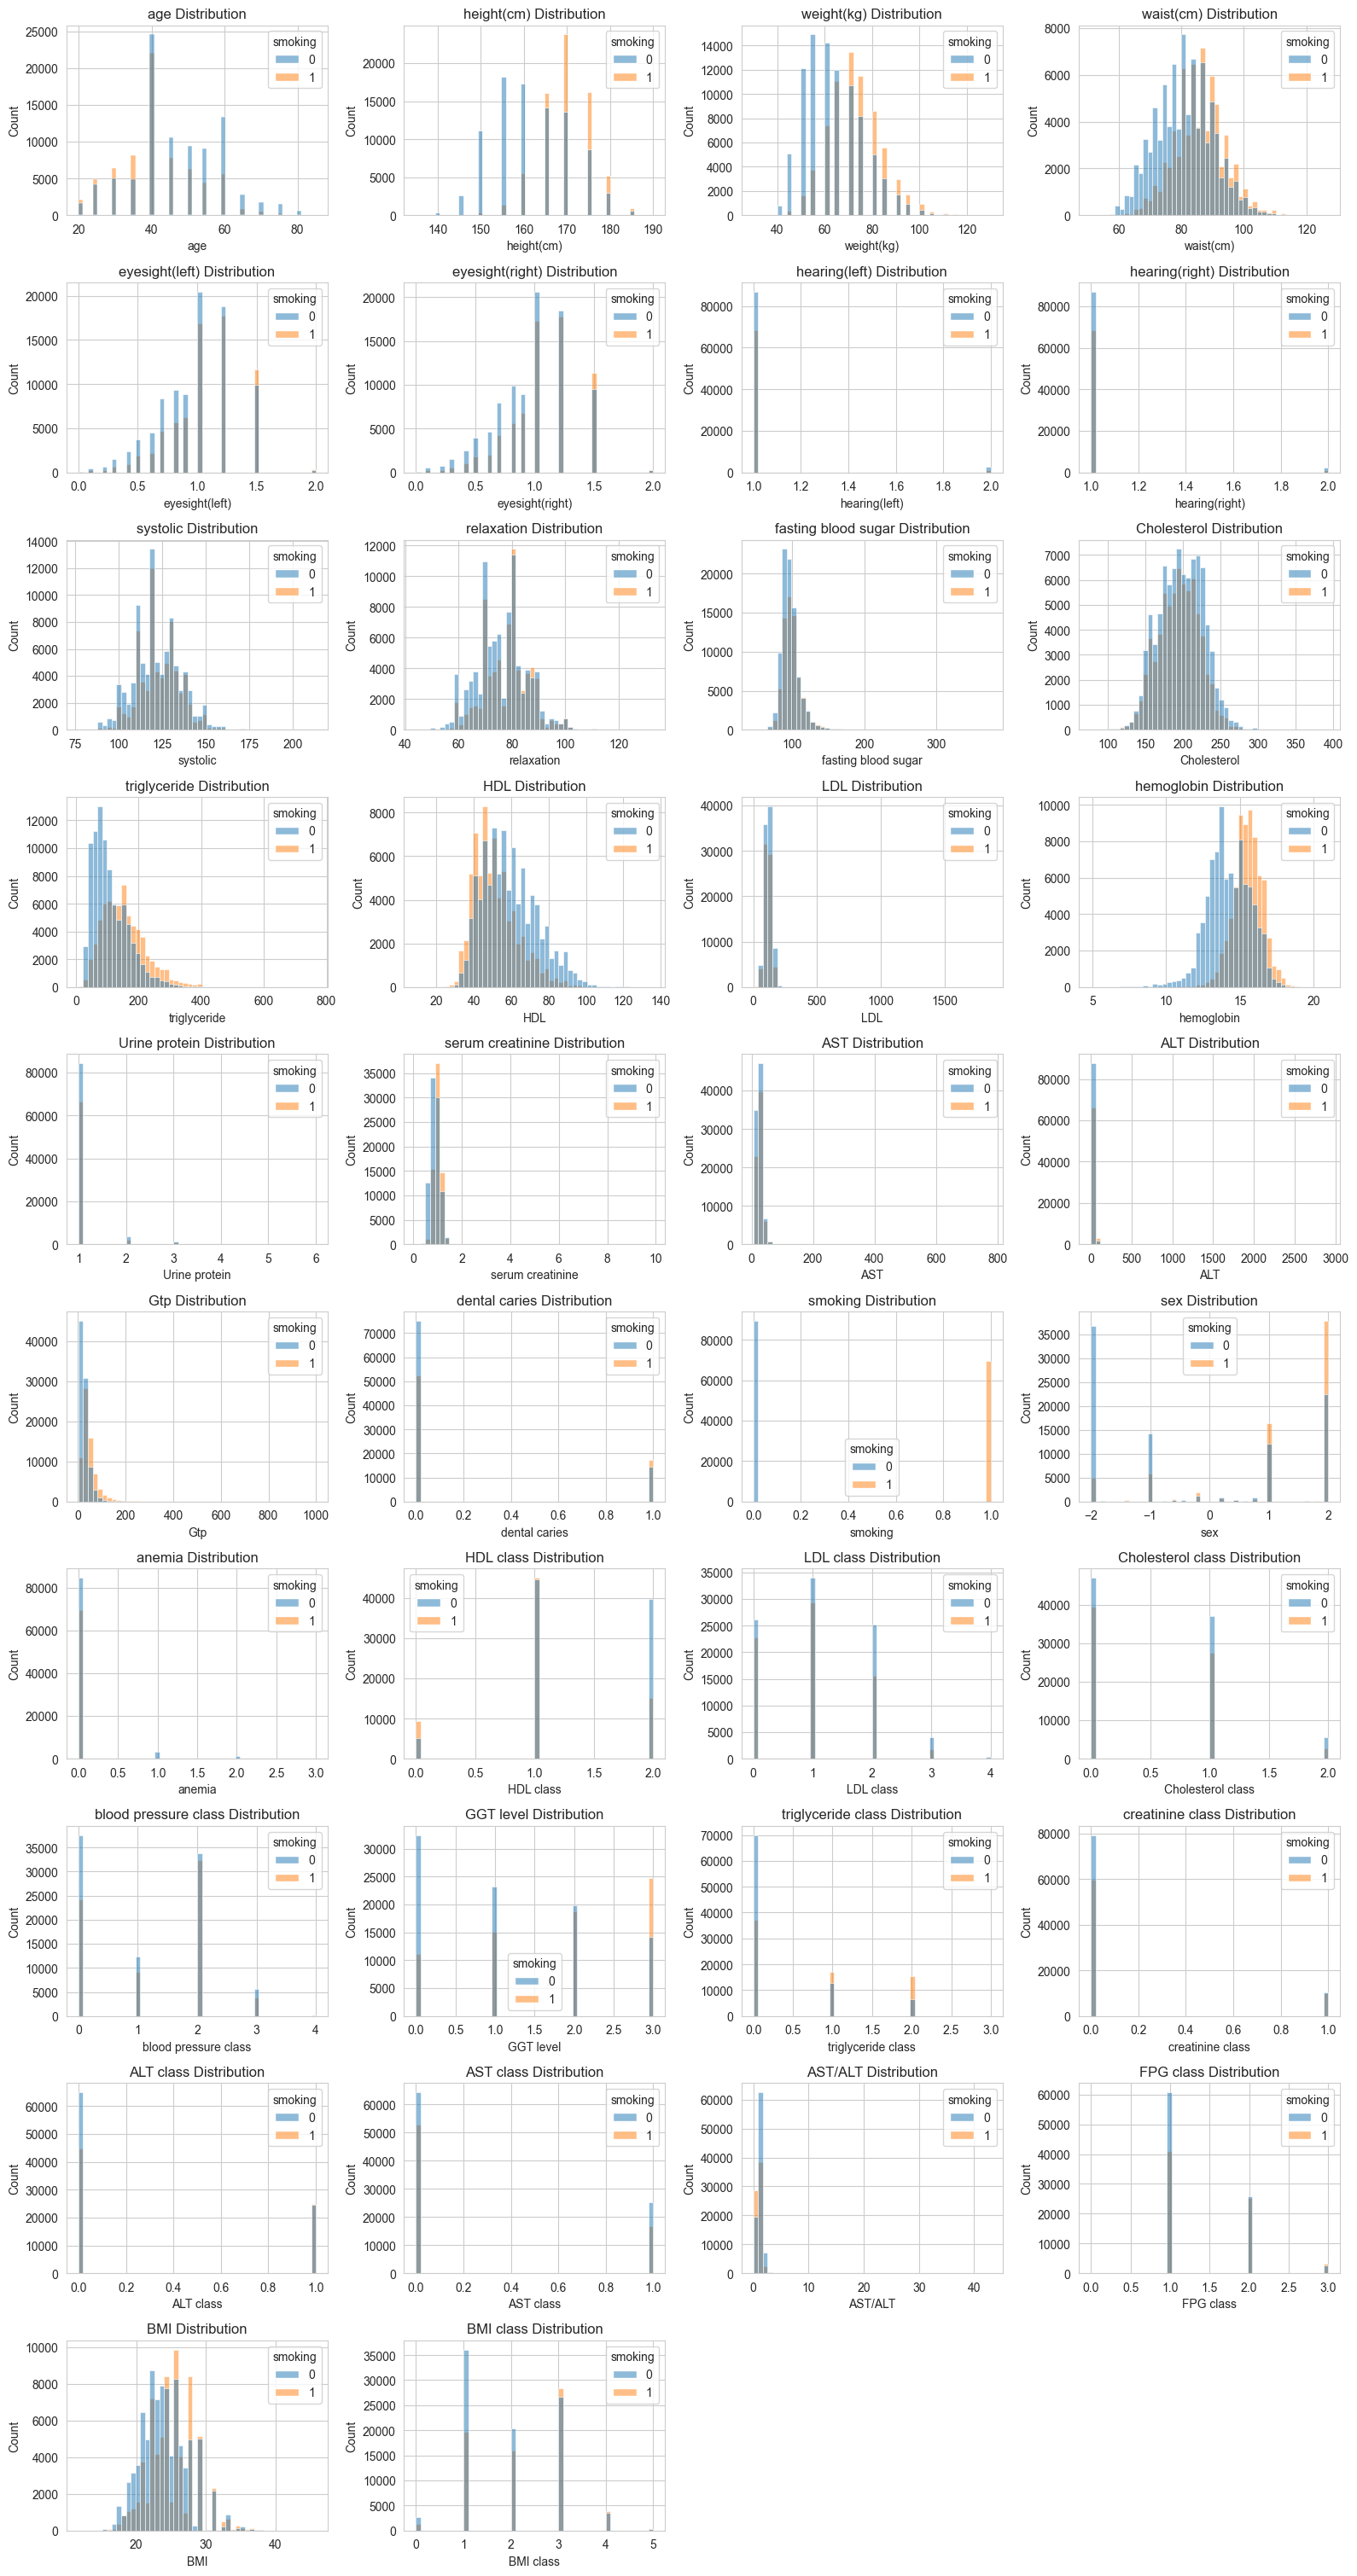

In [240]:
import seaborn as sns

sns.set_style('whitegrid')

# Took graph stuff from https://github.com/Koda98/smoker-status-prediction/blob/main/notebook.ipynb
num_cols = len(X.columns)
plt.figure(figsize=(16, num_cols * 1.5))
for i, col in enumerate(X.columns):
    plt.subplot(num_cols // 2 + num_cols % 2, 4, i + 1)
    sns.histplot(x=col, hue='smoking', data=X, bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()

In [252]:
from smoker_status.features import log_transform_X

X_copy = log_transform_X(X)

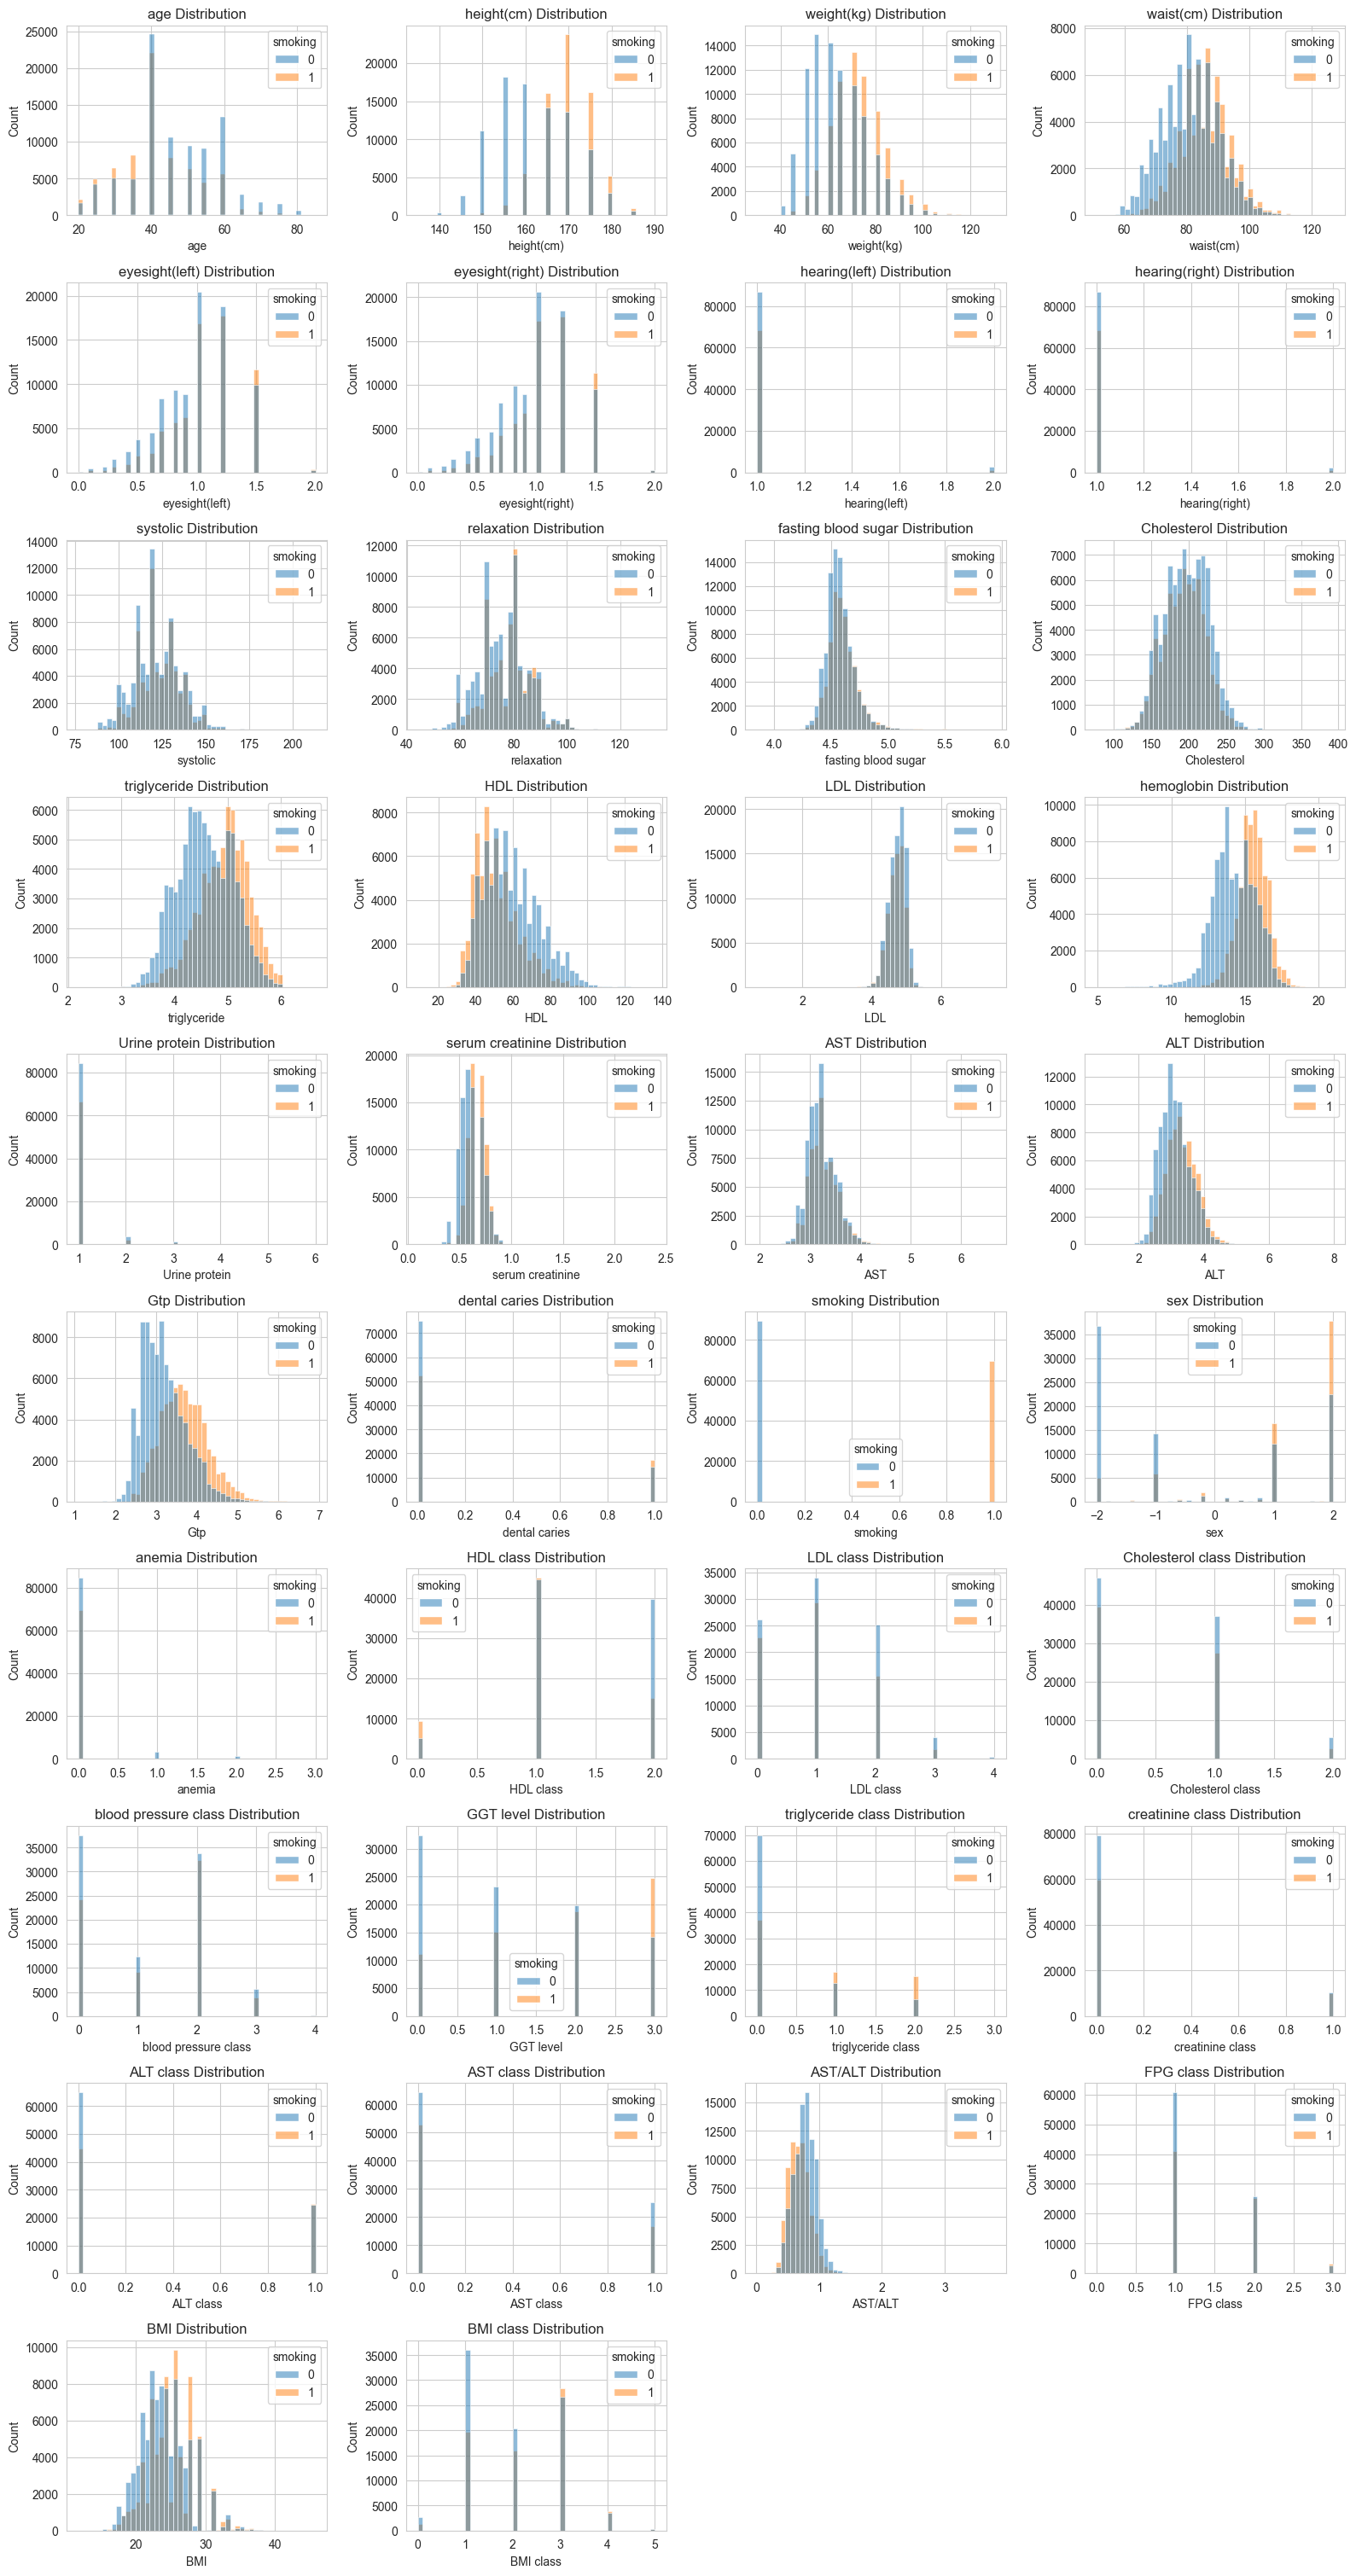

In [253]:
num_cols = len(X_copy.columns)
plt.figure(figsize=(16, num_cols * 1.5))
for i, col in enumerate(X_copy.columns):
    plt.subplot(num_cols // 2 + num_cols % 2, 4, i + 1)
    sns.histplot(x=col, hue='smoking', data=X_copy, bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()

In [254]:
X_copy.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,AST/ALT,FPG class,BMI,BMI class
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,44.306626,165.266929,67.143662,83.001990,0.997593,0.993716,1.023974,1.023421,122.503648,76.874071,4.588954,195.796165,4.724302,55.852684,4.722861,14.796965,1.074233,0.633630,3.233489,3.194559,3.411219,0.197996,0.437365,0.285549,0.044381,1.252844,1.031220,0.509149,1.153765,1.456755,0.464108,0.126871,0.309734,0.264354,0.730655,1.395816,24.452825,2.052695
std,11.842286,8.818970,12.586198,8.957937,0.311283,0.310485,0.152969,0.151238,12.729315,8.994642,0.134083,28.396959,0.526230,13.964141,0.237087,1.431213,0.347856,0.093911,0.286111,0.475563,0.603053,0.398490,0.496063,1.676109,0.258191,0.610643,0.856905,0.595055,1.019599,1.132330,0.724135,0.332830,0.462385,0.440990,0.180324,0.563515,3.368651,1.008344
min,20.000000,135.000000,30.000000,51.000000,0.000000,0.000000,1.000000,1.000000,77.000000,44.000000,3.850148,77.000000,2.197225,9.000000,0.693147,4.900000,1.000000,0.095310,1.945910,0.693147,1.098612,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010582,0.000000,11.718750,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,4.510860,175.000000,4.356709,45.000000,4.564348,13.800000,1.000000,0.587787,3.044522,2.833213,2.944439,0.000000,0.000000,-2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.597837,1.000000,22.222222,1.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,4.574711,196.000000,4.753590,54.000000,4.744932,15.000000,1.000000,0.641854,3.218876,3.135494,3.332205,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.723919,1.000000,24.221453,2.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,4.644391,217.000000,5.111988,64.000000,4.897840,15.800000,1.000000,0.693147,3.401197,3.496508,3.806662,0.000000,1.000000,2.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.847298,2.000000,26.159334,3.000000
max,85.000000,190.000000,130.000000,127.000000,2.000000,2.000000,2.000000,2.000000,213.000000,133.000000,5.929589,393.000000,6.642487,136.000000,7.528869,21.000000,6.000000,2.388763,6.658011,7.977625,6.907755,1.000000,1.000000,2.000000,3.000000,2.000000,4.000000,2.000000,4.000000,3.000000,3.000000,1.000000,1.000000,1.000000,3.784190,3.000000,45.785640,5.000000


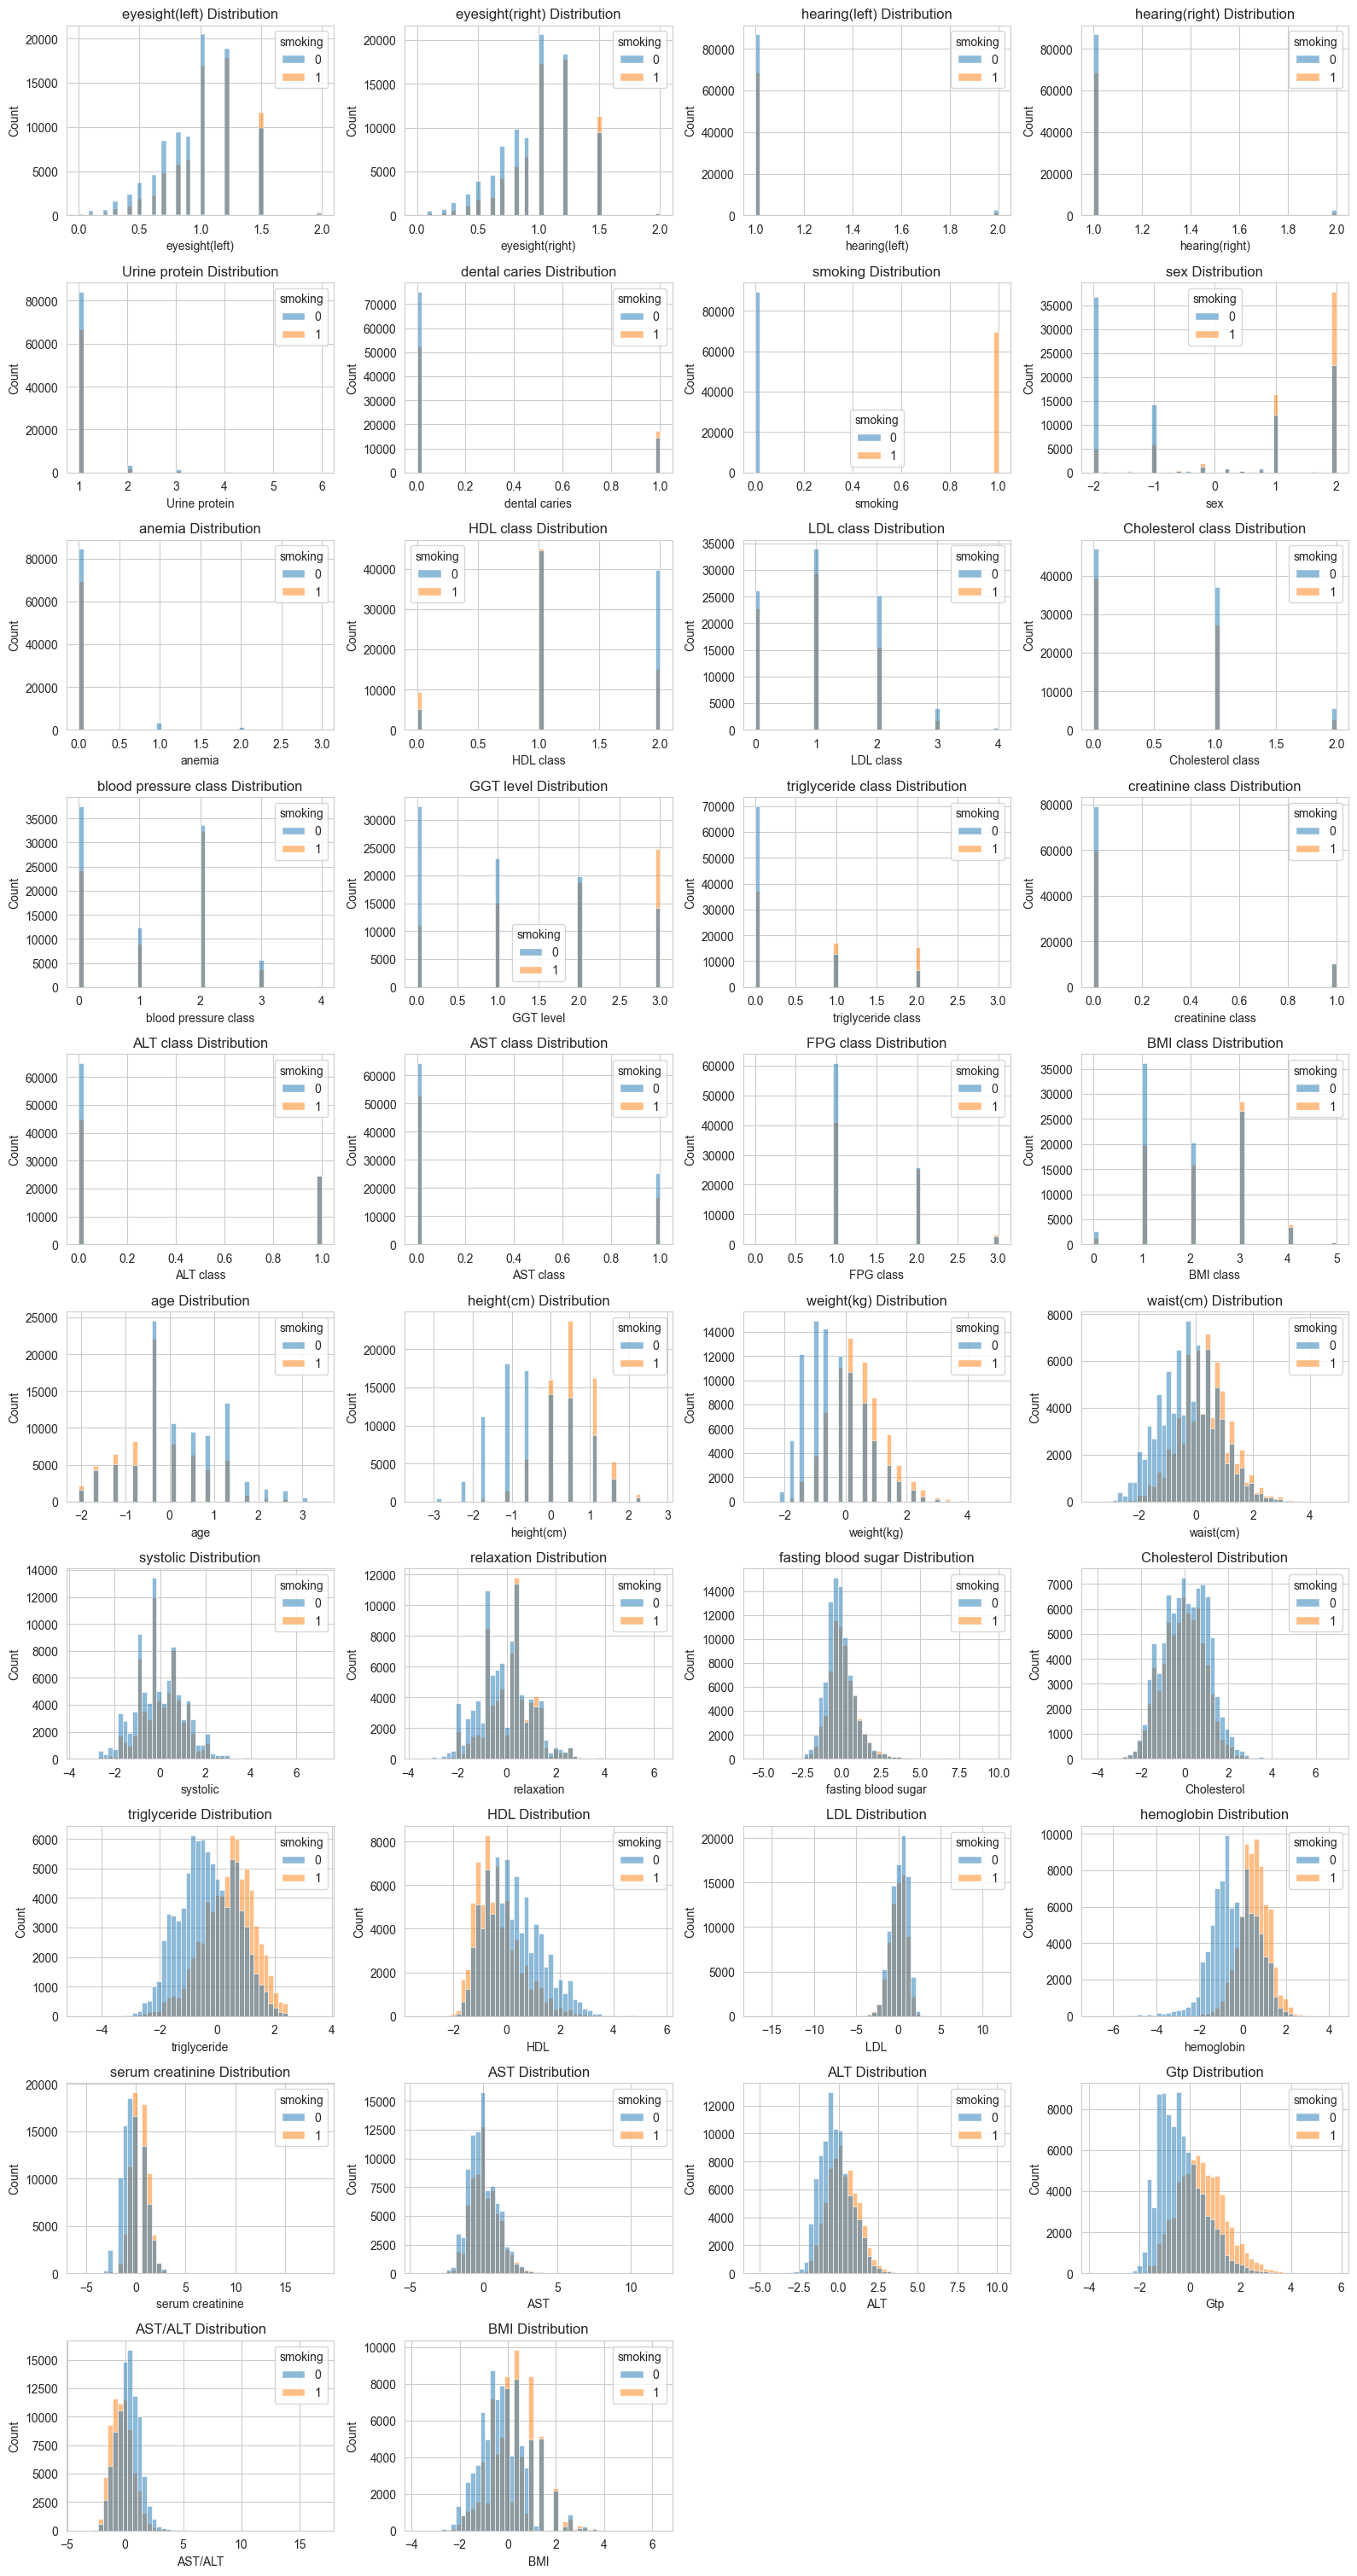

In [255]:
from smoker_status.features import scale_X
from smoker_status.util import plot_feature_histograms

X_copy_scaled = scale_X(X_copy)[1]
X_copy_scaled.describe()
plot_feature_histograms(X_copy_scaled)

In [260]:
X_copy_scaled[(X_copy_scaled['sex'] % 1 != 0) & (X_copy_scaled['sex'] % 1 != 0.2)  ]

,eyesight(left),eyesight(right),hearing(left),hearing(right),Urine protein,dental caries,smoking,sex,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI
52,1.2,1.0,1,1,1,0,1,-0.2,0,0,1,1,0,1,2,0,1,0,2,2,-0.363666,-0.030268,-0.170319,-0.335122,-0.982275,-0.764243,0.831773,0.500190,1.245837,-1.278470,0.610213,0.561089,0.087569,-0.497873,0.051133,-0.688975,-0.565909,-0.171497
57,0.4,0.6,1,1,1,0,0,-0.2,0,1,0,0,0,3,0,0,1,1,1,1,1.747419,-0.030268,-0.964843,0.223044,-1.767866,-1.876020,-0.340534,-2.035301,-0.264780,-0.419124,-2.000818,0.700831,-1.096810,0.345028,0.212965,0.141428,-0.102372,-1.261876
58,1.0,1.0,1,1,1,0,1,-0.2,0,1,0,0,0,3,2,1,1,1,1,2,-0.363666,-0.030268,-0.170319,0.669577,-1.217952,-1.876020,-0.500930,-0.415404,1.723414,-1.063634,-1.035592,0.561089,0.633762,2.228909,0.758659,0.895487,0.762148,-0.171497
63,1.5,1.5,1,1,1,1,0,0.8,0,2,0,0,2,1,0,0,0,0,1,3,0.902985,-0.597229,0.226943,1.127273,0.667465,0.792244,0.120939,-1.824010,-0.987422,1.371182,-3.018010,-0.626719,-3.164269,-0.660468,0.212965,-0.016619,-0.887907,0.858187
109,1.5,1.5,1,1,1,0,0,0.4,0,2,0,0,0,0,0,0,0,0,1,1,-1.208100,0.536694,-0.567581,-0.670021,-0.510921,0.125178,-0.500930,-1.154922,-1.874913,0.941509,-1.132559,0.071991,0.633762,-0.660468,-0.639638,-0.688975,0.260915,-1.095866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159171,0.8,1.2,1,1,1,0,1,1.8,0,1,2,1,0,1,0,1,0,0,1,4,-0.785883,-0.030268,1.418728,1.562643,-0.353802,0.125178,0.045983,1.098848,0.212796,-0.132675,1.157179,0.421347,1.648667,-0.193754,0.289438,0.090401,-0.634799,2.009261
159204,1.0,1.2,1,1,1,0,0,-0.2,0,1,2,1,2,3,0,0,1,1,1,2,-0.363666,-0.030268,-0.170319,-0.335122,0.431788,0.569889,-0.029735,0.535405,0.505731,-0.992021,0.922792,1.399541,0.087569,1.124951,1.709082,0.692184,-1.343710,-0.171497
159236,0.9,1.0,1,1,1,0,1,-0.2,0,2,1,0,0,2,0,0,0,0,1,1,1.325202,-0.030268,-0.964843,-0.446755,-0.589480,-0.986598,-0.183515,-0.063252,-2.015742,0.583447,0.376754,1.679025,-0.488163,-1.010276,-1.323928,-0.253913,1.029457,-1.261876
159247,1.2,1.5,1,1,1,0,0,-0.2,0,2,0,0,0,1,0,0,0,0,3,1,-2.052535,0.536694,-0.964843,-1.339820,-0.982275,-0.097177,2.788515,-0.591479,-1.015999,1.227957,-0.757390,0.770702,0.087569,-1.010276,-0.525947,-0.958469,-0.208005,-1.609457


In [261]:
_X = X_copy_scaled.copy(deep=True)
y = _X.pop('smoking')
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
scores = cross_val_score(clf, _X, y, cv=10, scoring='accuracy', n_jobs=-1)
scores.mean()

np.float64(0.7741184252678843)

In [267]:
from smoker_status.features import one_hot_encode_X

_X = one_hot_encode_X(X_copy_scaled)[1]
_X


C:\Users\tooth\Desktop\gross\smoker-status\smoker_status\features.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_only_feats['sex'] = X_only_feats.apply(lambda x:  0 if x['sex'] < 0 else 1, axis=1)


,eyesight(left),eyesight(right),Urine protein,smoking,anemia,HDL class,LDL class,Cholesterol class,blood pressure class,GGT level,triglyceride class,creatinine class,ALT class,AST class,FPG class,BMI class,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,AST/ALT,BMI,hearing(left) - normal,hearing(left) - abnormal,hearing(right) - normal,hearing(right) - abnormal,dental caries - nonpresent,dental caries - present,sex - M,sex - F
0,0.5,0.6,1,1,0,1,0,0,2,1,2,0,0,0,1,1,0.902985,-0.030268,-0.567581,-0.223489,0.981702,1.125777,-0.261612,-0.837985,1.867645,-1.135246,-1.653948,1.189928,0.633762,-0.342507,0.133605,-0.131025,-0.551141,-0.716686,1,0,1,0,1,0,0,1
1,0.6,0.7,1,0,0,1,1,0,2,2,0,0,0,0,3,2,2.169636,-0.030268,-0.170319,0.669577,1.845852,0.681066,3.044832,-0.063252,-1.328226,0.082162,0.511737,0.980315,1.153301,0.345028,-0.034707,0.375369,0.254395,-0.171497,0,1,0,1,0,1,0,1
2,0.4,0.5,1,1,0,1,0,0,0,3,1,0,0,0,1,3,-2.052535,0.536694,0.624205,-0.223489,-0.353802,-0.208355,-1.543290,-0.626695,1.071711,-0.777185,-0.757390,1.818767,-0.488163,0.345028,0.570224,0.958070,-0.577848,0.444907,1,0,1,0,1,0,0,1
3,1.5,1.2,1,0,0,0,1,0,2,1,2,0,0,0,1,3,-0.785883,1.670617,2.213252,2.455708,0.667465,1.236955,-0.500930,-0.556264,1.128441,-1.278470,-0.371731,0.770702,0.633762,-0.660468,0.289438,0.037755,-0.977935,1.445142,1,0,1,0,0,1,0,1
4,1.5,1.0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,-1.208100,-0.030268,-0.567581,-0.279305,-0.118125,-0.097177,-0.500930,-1.436643,-0.469312,-0.848797,-0.757390,0.421347,-0.488163,-0.830998,-1.168096,-0.863687,0.943477,-0.716686,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,1.5,2.0,1,0,0,2,2,1,2,0,0,0,1,0,0,1,-0.363666,-1.164191,-1.759366,-1.563087,0.353229,0.347533,-3.091887,1.486214,-1.621161,1.156345,1.486011,-0.207493,-0.488163,0.086008,0.212965,-1.280426,-0.315690,-1.698708,1,0,1,0,1,0,1,0
159252,1.0,1.0,1,0,0,2,1,1,2,0,2,0,0,0,1,4,0.480768,-1.164191,0.624205,-0.111855,-0.196684,0.347533,-0.664851,0.605836,1.119102,0.583447,-0.132920,-0.207493,-1.742368,-0.497873,-0.315493,-0.774031,-0.071070,2.008127,1,0,1,0,1,0,0,1
159253,1.5,1.0,1,0,2,2,0,0,0,0,0,0,0,0,1,1,-0.363666,-0.597229,-1.362104,-1.897986,-0.668039,-0.764243,-1.091145,-0.239328,-1.702038,2.230528,-0.757390,-2.722849,-1.742368,-1.610921,-1.875622,-1.403314,1.387361,-1.460997,1,0,1,0,1,0,1,0
159254,1.2,1.0,1,1,0,1,0,0,3,2,0,0,0,0,2,3,0.480768,-0.030268,0.624205,1.004477,-0.118125,1.459310,1.664874,-1.084492,0.531412,-0.061063,-1.385202,-0.277364,1.153301,-0.342507,-0.639638,0.375369,0.552856,0.918882,1,0,1,0,1,0,0,1


In [268]:
y = _X.pop('smoking')
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
scores = cross_val_score(clf, _X, y, cv=10, scoring='accuracy', n_jobs=-1)
scores.mean()

np.float64(0.7739049426202149)

Looks like one hot encoding doesn't really do anything. Think that helps confirm my suspicion that those columns aren't even categorical.

Seems like there's an ordering to them: (the presence of cavities is worse than the absence)